In [9]:
import math
import numpy as np
import scipy.special
import scipy.stats
import matplotlib.pyplot as plt

In [10]:
# Constants for the different scripts
b   = 2
m   = 12
N   = b**m
N_2 = b**(m//2)
print(str(N) + ' = ' + str(N_2) + ' * ' + str(N_2))

4096 = 64 * 64


In [11]:
# Convert an integer to a bit vector representation. This is very much
# not efficient, but it allows to access the bit vector representation
# using brackets.
# 
# Those function take as input an integer (for index2vector) or a bit
# vector (for vector2real) and output either the vector of bits or a
# floatting point representation in [0,1] of the binary representation
# using x = \sum n_i 2^{-(i+1)}
#
def index2vector(n, b=2, m=8):
    bk = 1
    nk = np.empty([m], int)
    for k in range(0, m):
        nk[k] = (n/bk) % b
        bk *= b
    return nk

def vector2index(nk):
    n = 0
    for b in nk:
        n = (n<<1) +  b    
    return n

def vector2real(n, b, m):
    ob = 1.0/b
    bk = ob
    xn = 0.0
    for k in range(0, m):
        xn += n[k]*bk
        bk *= ob
    return xn

In [12]:
# Create a vector of linearly blended colors that can be used in
# matplolib as a colormap for `pyplot.scatter` for example.
#
# This function takes as input the number of colors points and
# optionnaly, the first and last colors.
#
def color_vector(N, c0=[1,0,0], c1=[0,0,1]):
    colors = np.zeros((N, 3))
    for i in range(0, N):
        u0 = float(i)/float(N-1)
        u1 = 1.0 - u0
        colors[i, 0] = u0*c0[0] + u1*c1[0]
        colors[i, 1] = u0*c0[1] + u1*c1[1]
        colors[i, 2] = u0*c0[2] + u1*c1[2]
    return colors;

In [13]:
def plot_sequence(xy, b=2, m=6, colors='black', plot_lines=False, shift_points=True):
    # Plot the curve and the points
    shift_x = 0.5/(b**(m//2)) if (shift_points) else 0.0
    shift_y = shift_x
    plt.scatter(xy[:,0] + shift_x, xy[:,1] + shift_y, zorder=2, color=colors);
    if plot_lines:
        plt.plot(xy[:,0] + shift_x, xy[:,1] + shift_y, zorder=1, c='gray');
    plt.axis('square');
    plt.grid(True);
    plt.xticks(np.linspace(0, 1, b**(m//2)+1));
    plt.yticks(np.linspace(0, 1, b**(m//2)+1));

In [28]:
def morton_curve(N):
    xy = np.zeros([len(N), 2])
    for n in N:
        nk = index2vector(n, b, m)
        s  = 1.0
        for i in reversed(range(0, m//2)):
            s *= 0.5
            uv = [ nk[2*i+0], nk[2*i+1] ]
            xy[n][0] += s * float(nk[2*i+0])
            xy[n][1] += s * float(nk[2*i+1])
    return xy

def morton_curve_from_binary(NK):
    xy = np.zeros([NK.shape[0], 2])
    for n in range(0, NK.shape[0]):
        nk = NK[n]
        s  = 1.0
        for i in reversed(range(0, m//2)): # Level traversal
            s *= 0.5
            uv = [ nk[2*i+0], nk[2*i+1] ]
            xy[n][0] += s * float(nk[2*i+0])
            xy[n][1] += s * float(nk[2*i+1])
    return xy

In [124]:
C1 = np.matrix(np.zeros([m,m], int))
C2 = np.matrix(np.zeros([m,m], int))
for k in range(0, m):
    C1[k,k] = 1
    for l in range(k, m):
        C2[k,l] = scipy.special.binom(l, k) % b

C1 = C1.transpose()
C2 = C2.transpose()
# print(C2)

iC1 = np.linalg.inv(C1)
iC2 = np.linalg.inv(C2)

T12 = iC1*C2
T21 = iC2*C1

# print("C1 = " + str(C1))
# print("C2 = " + str(C2))

sobol_xy = np.empty([N,2], float)
for n in range(0, N):
    nk = index2vector(n, b, m)

    nk1 = np.mod((nk*C1).A[0], b)
    nk2 = np.mod((nk*C2).A[0], b)

    y1 = vector2real(nk1, b, m)
    y2 = vector2real(nk2, b, m)
    
    sobol_xy[n, 0] = y1
    sobol_xy[n, 1] = y2

## The Golden Ratio nD Sequence

In [43]:
# Use Newton-Raphson-Method to calculate g=phi_d 
# or you could just hard-code it. 
# phi(1) = 1.61803398874989484820458683436563 
# phi(2) = 1.32471795724474602596090885447809 
def phi(d): 
  x=1.0000 
  for i in range(20): 
    x = x-(pow(x,d+1)-x-1)/((d+1)*pow(x,d)-1) 
  return x

# Number of dimensions. 
d=2 

g = phi(d) 
alpha = np.zeros(d) 
for j in range(d): 
  alpha[j] = pow(1.0/g,j+1.0) % 1.0 
golden_xy = np.zeros((N, d)) 

# This number can be any real number. 
# Default setting is typically is seed=0
# But seed = 0.5 is marginally better in theory and practice. 
for i in range(N): 
  golden_xy[i] = (alpha*(i)) % 1.0 

## Dither Mask with 2D Values

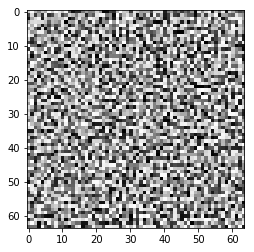

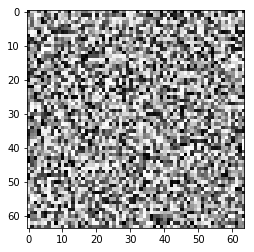

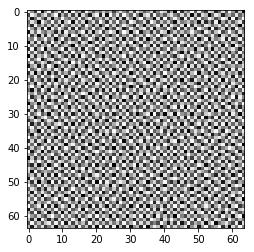

In [132]:
# Load the CSV image
pixels = np.loadtxt('pixels.txt', dtype=int, delimiter=' ')
size = pixels.shape[0]
assert(size == N)

# Generate the (v_1, ... v_n) elements
vk = np.zeros([N, 2])

# Using z-curve
# vk = morton_curve(range(0, size))

# using Sobol
# temp_xy = sobol_xy.copy()

# using a 1d rank lattice
temp_xy = golden_xy.copy()

# using a regular grid
# vk[...,0] = np.linspace(0, 1, N)
# vk[...,1] = np.linspace(0, 1, N)

# Optional reordering
vk      = np.array([temp_xy[0, :]])
temp_xy = np.delete(temp_xy, 0, 0)
while(temp_xy.shape[0] > 0):
    min_d = 100000.0
    min_i = 0
    min_v = np.array([0,0])
    for i in range(0, temp_xy.shape[0]):
        xy = temp_xy[i]
        d  = np.linalg.norm(xy - vk[0])
        
        if d < min_d:
            min_i = i
            min_d = d
            
    vk      = np.insert(vk, 0, temp_xy[min_i], axis=0)
    temp_xy = np.delete(temp_xy, min_i, 0)
    

# Show the masks and the classical one
mask = np.zeros([N_2, N_2, 3])
for n in range(0, size):
    ij = pixels[n]
    vn = vk[n]
    
    i = ij[0]
    j = ij[1]
    mask[i][j][0] = vn[0] + 0.5/N_2
    mask[i][j][1] = vn[1] + 0.5/N_2
    mask[i][j][2] = n / size

plt.figure()
plt.imshow(mask[...,0], cmap="Greys");
plt.figure()
plt.imshow(mask[...,1], cmap="Greys");
plt.figure()
plt.imshow(mask[...,2], cmap="Greys");    

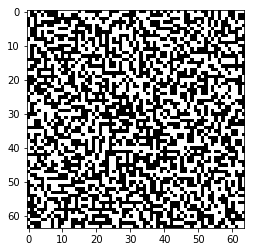

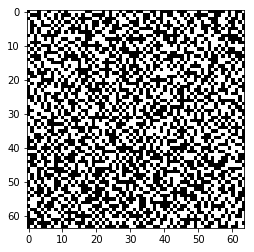

In [127]:
plt.figure()
plt.imshow(mask[...,0] > 0.5, cmap="Greys")
plt.figure()
plt.imshow(mask[...,1] > 0.5, cmap="Greys")